In [1]:
import pylabnet.hardware.ZI_HDAWG.zi_hdawg as zi_hdawg
from pylabnet.utils.logging.logger import LogClient

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, display

import pyvisa
from pylabnet.utils.logging.logger import LogClient
from pylabnet.network.client_server.agilent_e4405B import Client
import pylabnet.hardware.spectrum_analyzer.agilent_e4405B as sa_hardware


import itertools as it
import pandas as pd
import seaborn as sns
from noisyopt import minimizeCompass

from pylabnet.utils.logging.logger import LogService
from pylabnet.network.core.generic_server import GenericServer
import os
import sys

# from execution_time import ExecutionTime

# from notebook.services.config import ConfigManager
# ConfigManager().update('notebook', {'ExecuteTime': {
#     'display_absolute_timestamps': False,
#     'relative_timing_update_period': 5,
#     'template': {
#         'executed': 'started ${start_time}, finished in ${duration}',
#     }
# }})

# Instantiante HDAWG

In [2]:
dev_id = 'dev8227'

# Instantiate
logger = LogClient(
    host='localhost',
    port=12351,
    module_tag=f'ZI HDAWG {dev_id}'
)

In [3]:
# Instanciate Hardware class
hd = zi_hdawg.Driver(dev_id, logger)

# Select channel grouping
hd.set_channel_grouping(0)

# Connect to Spectrum Analyzer

In [4]:
sa = Client(
    host='localhost',
    port=12356
)

# Reset spectrum analzyer
sa.write('*RST')

(6, <StatusCode.success: 0>)

# Setup I/Q Outputs

For reference, we're using the following I/Q mixer https://www.markimicrowave.com/Assets/datasheets/MMIQ-0218H.pdf?v=061820. The local oscillator is set to 12 GHz at a power of 24 dBm. 

In [5]:
carrier = 12*1e9 # 12 GHz
signal_freq = 300*1e6 # 300 MHz
phase = 0
amplitude_i = 650*1e-3
amplitude_q = 650*1e-3

In [6]:
# Assign oscillator 1 to sine output 2
hd.seti('sines/1/oscselect', 0)

# Set carrier frequency
hd.setd('oscs/0/freq', signal_freq)

# Set I and Q amplitude
hd.setd('sines/0/amplitudes/0', amplitude_i)
hd.setd('sines/1/amplitudes/1', amplitude_q)

# Set phase offset between I and Q
hd.setd('sines/0/phaseshift', phase)

# Enable sine waves
hd.seti('sines/0/enables/0', 1)
hd.seti('sines/1/enables/1', 1)

In [7]:
# Enable wave output on and 2
def enable():
    hd.enable_output(0)
    hd.enable_output(1)
    
# disable wave output on and 2
def disable():
    hd.disable_output(0)
    hd.disable_output(1)

In [8]:
enable()

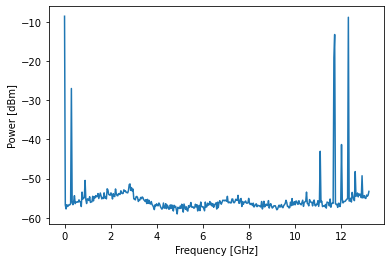

In [9]:
sa.plot_trace()

In [10]:
# Center frequency at carrier frequency
sa.set_center_frequency(carrier)
sa.set_frequency_span(6*signal_freq)

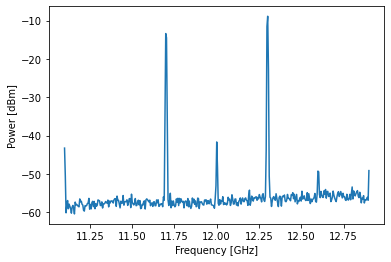

In [11]:
sa.plot_trace()

# Set markers

In [12]:
# Marker for upper sideband.
upp_sb_marker = sa_hardware.E4405BMarker(sa,'Upper Sideband',1)
lower_sb_marker = sa_hardware.E4405BMarker(sa,'Lower Sideband',2)
carrier_marker = sa_hardware.E4405BMarker(sa,'Carrier',3)

In [13]:
upp_sb_marker.look_right()

In [14]:
lower_sb_marker.look_left()

In [15]:
# define target frequencies
markers = [upp_sb_marker, lower_sb_marker, carrier_marker]
target_freqs = np.array([12.3, 11.7, 12])*1e9
max_deviation = 1e6 # How much 

In [16]:
for marker, target_freq in zip(markers, target_freqs):
    marker_freq = marker.read_freq()
    
    assert abs(marker_freq - target_freq) < max_deviation, f"{marker.name} has wrong frequecy: {marker_freq / 1e9} GHz"
    print(f"Marker '{marker.name}' parked at {marker_freq / 1e9:.4f} GHz reads {marker.get_power():.2f} dbm.")

Marker 'Upper Sideband' parked at 12.3000 GHz reads -8.87 dbm.
Marker 'Lower Sideband' parked at 11.7000 GHz reads -13.40 dbm.
Marker 'Carrier' parked at 12.0000 GHz reads -41.80 dbm.


## DC offset calibration

Let's try the DC calibration the hard way: Sweep through a reasonable range of DC-offset parameters for the I and Q curve and inspect the combination yielding highest carrier suppression:

In [17]:
# Define area of 2D sweep of DC offest
dc_min_i = 0
dc_max_i = 100e-3
dc_max_q = 0
dc_min_q = -100e-3

num_points = 10

In [18]:
def sweep_dc_offsets(dc_min_i, dc_max_i, dc_min_q, dc_max_q, num_points):
    # Sweep 2D parameter space of DC offsets and record carrier power
    voltages_i = np.linspace(dc_min_i, dc_max_i, num_points)
    voltages_q = np.linspace(dc_min_q, dc_max_q, num_points)

    carrier_power = np.zeros((num_points, num_points))

    for i, j in it.product(range(num_points), repeat=2):

        # Set I DC-offset
        hd.setd('sigouts/0/offset', voltages_i[i])

        # Set Q DC-offset
        hd.setd('sigouts/1/offset', voltages_q[j])

        # Read carrier power
        carrier_power[i,j] = carrier_marker.get_power()
        print(f'{i/num_points * 100} % done')
        clear_output(wait=True)
        
    return carrier_power, voltages_i, voltages_q

In [19]:
carrier_power, voltages_i, voltages_q = sweep_dc_offsets(dc_min_i, dc_max_i, dc_min_q, dc_max_q, num_points)

90.0 % done


In [20]:
# Store results in dataframe for easy plotting
dc_sweep_data = pd.DataFrame(carrier_power,
                   columns=np.round(voltages_q/1e-3, 1),
                   index=np.round(voltages_i/1e-3, 1))

[Text(0.5, 24.0, 'DC offset Q signal [mV]'),
 Text(51.0, 0.5, 'DC offset I signal [mV]')]

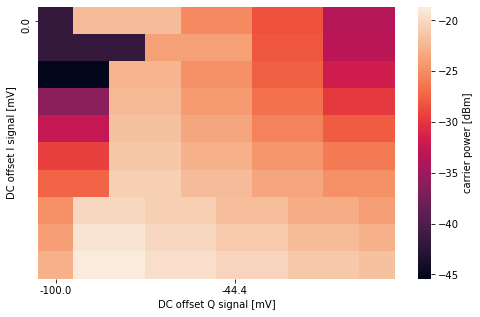

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))    
ax = sns.heatmap(dc_sweep_data, xticklabels=5,  yticklabels=10,  cbar_kws={'label': 'carrier power [dBm]'})
ax.set(xlabel='DC offset Q signal [mV]', ylabel='DC offset I signal [mV]')

We seem to be able to extract a set of DC-offests which highly supresses the carrier. However, without a good initial guess, this brute force method is slow. Let's rather try an optimization algorithm:

In [22]:
# Define minimization function

# Store voltage values during optimization
dc_offset_traces = []
carrier_power_traces = []


def min_carrier(dc):
     
    # Manually check constraints to make sure we can trust bounds
    # in optimizer function.
    assert dc_min_i <= dc[0] <= dc_max_i, f"{dc[0]} out of bound"
    assert dc_min_q <= dc[1] <= dc_max_q, f"{dc[1]} out of bound"
    
    # Append to storage
    dc_offset_traces.append(dc)
    
    # Set I DC-offset
    hd.setd('sigouts/0/offset', dc[0])
        
    # Set Q DC-offset
    hd.setd('sigouts/1/offset', dc[1])
    
    # Read carrier
    power = carrier_marker.get_power()
    carrier_power_traces.append(power)
    
    # Print for debugging purposes.
    print(f'Trying dc_i={dc[0]*1000:,.4f} mV, dc_q={dc[1]*1000:,.4f} mV, power={power}')   
    clear_output(wait=True)
    
    return power

In [23]:
# Run minimization function

x0 = np.array([0, 0])
bounds = [(dc_min_i, dc_max_i), (dc_min_q, dc_max_q)]
res = minimizeCompass(min_carrier, bounds=bounds, x0=x0, deltatol=0.001, paired=False, deltainit=1)

Trying dc_i=8.3125 mV, dc_q=0.0000 mV, power=-49.2


In [24]:
# Retrieve optimal DC offests
dc_offset_i_opt = res['x'][0]
dc_offset_q_opt = res['x'][1]

# Set optimal offset
hd.setd('sigouts/0/offset', dc_offset_i_opt)
hd.setd('sigouts/1/offset', dc_offset_q_opt)

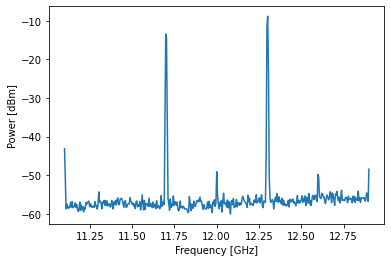

In [25]:
sa.plot_trace()

We have sucessfully supressed the carrier. Let's look at the convergence of our optimizatio routine:

In [26]:
# Generate convergence plots
dc_offest_is = np.asarray(dc_offset_traces)[:,0]
dc_offest_qs = np.asarray(dc_offset_traces)[:,1]

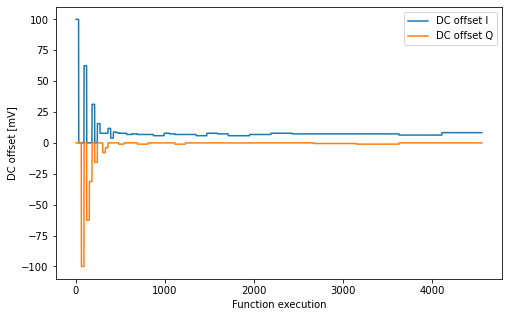

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))    
plt.plot(dc_offest_is*1000, label='DC offset I')
plt.plot(dc_offest_qs*1000, label='DC offset Q')
plt.xlabel('Function execution')
plt.ylabel('DC offset [mV]')
plt.legend()

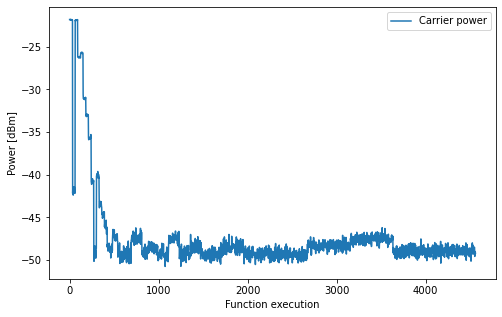

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))    
plt.plot(carrier_power_traces, label='Carrier power')
plt.xlabel('Function execution')
plt.ylabel('Power [dBm]')
plt.legend()

## Calibrate Phase

Let's now follow the same appraoch to suppress the lower sideband by performing a 2D sweep over the phase / amplitude imbalance space. We will impose that the sum of I and Q amplitudes is fixed: $A_I + A_Q = 2A_0$, and we sweep the ratio $q$ between the two amplitudes: $\frac{A_I}{A_Q} = q$. We thus get: $A_Q = 2  A_0 \frac{1}{1+q}$ and  $A_I = 2  A_0 \frac{q}{1+q}$ 

In [17]:
# Sweep phase offset in region of interest:
phase_min = 55
phase_max = 70

# Sweep amplitude imbalance 
q_min = 0.7
q_max = 1
a0 = 650*1e-3

num_points = 20

phases = np.linspace(phase_min, phase_max, num_points)
qs = np.linspace(q_min, q_max, num_points)


lower_sideband_power = np.zeros((num_points, num_points))
upper_sideband_power = np.zeros((num_points, num_points))
# lower_divided_by_upper = np.zeros((num_points, num_points))

In [18]:
def sweep_phase_amp_imbalance():

    carrier_power = np.zeros((num_points, num_points))

    for i, j in it.product(range(num_points), repeat=2):
        
            
        phase = phases[i]
        q = qs[j]
        
        # Calculate amplitudes
        amp_i = 2 * q / (1 + q) * a0
        amp_q = 2 * a0 / (1 + q)
        
        # Set I and Q amplitudes
        hd.setd('sines/0/amplitudes/0', amp_i)
        hd.setd('sines/1/amplitudes/1', amp_q)
        
        # Set phaseshift
        hd.setd('sines/0/phaseshift', phase)

        # Read and upper
        lower_sideband_power[i,j] = lower_sb_marker.get_power()
        upper_sideband_power[i,j] = upp_sb_marker.get_power()
        
#         lower_divided_by_upper[i,j] = lower_sb_marker.get_power() - upp_sb_marker.get_power()

        
        print(f'{i/num_points * 100} % done')
        clear_output(wait=True)

In [19]:
# Run sweep
sweep_phase_amp_imbalance()

95.0 % done


In [20]:
# Store results in dataframe for easy plotting
lower_sideband_data = pd.DataFrame(lower_sideband_power,
                   index=np.round(phases, 1),
                   columns=np.round(qs, 2))

upper_sideband_data = pd.DataFrame(upper_sideband_power,
                   index=np.round(phases, 1),
                   columns=np.round(qs, 2))

# sideband_ratio_data = pd.DataFrame(lower_divided_by_upper,
#                    index=np.round(phases, 1),
#                    columns=np.round(qs, 2))

[Text(51.0, 0.5, 'Phase shift'), Text(0.5, 24.0, 'Amplitude imbalance')]

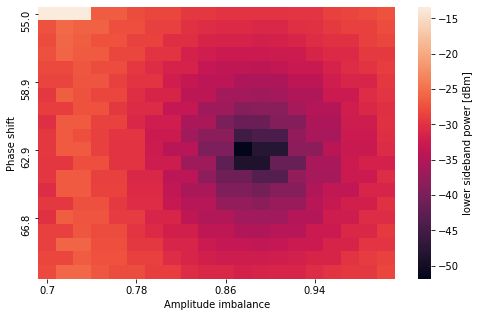

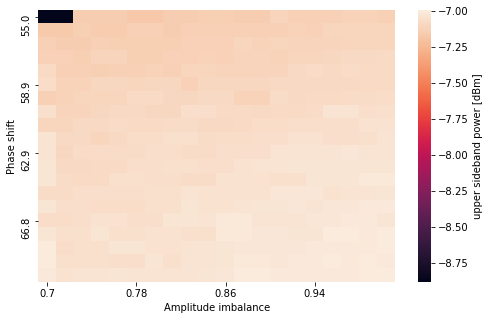

In [21]:
fig1, ax1 = plt.subplots(figsize=(8, 5))    
ax1 = sns.heatmap(lower_sideband_data, xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'lower sideband power [dBm]'})
ax1.set(ylabel='Phase shift', xlabel='Amplitude imbalance')

fig2, ax2 = plt.subplots(figsize=(8, 5))    
ax2 = sns.heatmap(upper_sideband_data, xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'upper sideband power [dBm]'})
ax2.set(ylabel='Phase shift', xlabel='Amplitude imbalance')

# fig3, ax3 = plt.subplots(figsize=(8, 5))    
# ax3 = sns.heatmap(sideband_ratio_data, xticklabels=25,  yticklabels=25,  cbar_kws={'label': 'lower/upper sideband power [dBm]'})
# ax3.set(ylabel='Phase shift', xlabel='Amplitude imbalance')

In [22]:
def set_optimal_point(opt_phase, opt_q):
    ''' Set phase and ampitude imbalance to optimal value'''
    amp_i_opt = 2 * opt_q / (1 + opt_q) * a0 
    amp_q_opt = 2 * a0 / (1 + opt_q) 

    # Set optimal I and Q amplitudes
    hd.setd('sines/0/amplitudes/0', amp_i_opt)
    hd.setd('sines/1/amplitudes/1', amp_q_opt)

    # Set optimal phaseshift
    hd.setd('sines/0/phaseshift', opt_phase)

In [23]:
# Read off optimal values
opt_phase = phases[np.where(lower_sideband_power == np.amin(lower_sideband_power))[0][0]]
opt_q = qs[np.where(lower_sideband_power == np.amin(lower_sideband_power))[1][0]]

print(opt_phase, opt_q)

62.89473684210526 0.8736842105263158


In [24]:
amp_i_opt = 2 * opt_q / (1 + opt_q) * a0
amp_q_opt = 2 * a0 / (1 + opt_q) 

# Set optimal I and Q amplitudes
hd.setd('sines/0/amplitudes/0', amp_i_opt)
hd.setd('sines/1/amplitudes/1', amp_q_opt)

# Set optimal phaseshift
hd.setd('sines/0/phaseshift', opt_phase)

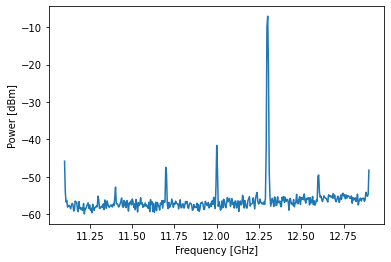

In [25]:
sa.plot_trace()

In [26]:
# Finer sweep over portion of phase-amplitude-imbalance space to obtain more accurate minimum

cushion_param = 2
q_cushion = cushion_param*(q_max-q_min)/num_points
phase_cushion = cushion_param*(phase_max-phase_min)/num_points

# Reset sweep window to zoom in on minimum
q_max = opt_q + q_cushion
q_min = opt_q - q_cushion
phase_max = opt_phase + phase_cushion
phase_min = opt_phase - phase_cushion

num_points = 30

phases = np.linspace(phase_min, phase_max, num_points)
qs = np.linspace(q_min, q_max, num_points)


lower_sideband_power = np.zeros((num_points, num_points))
upper_sideband_power = np.zeros((num_points, num_points))
# lower_divided_by_upper = np.zeros((num_points, num_points))

sweep_phase_amp_imbalance()

96.66666666666667 % done


[Text(51.0, 0.5, 'Phase shift'), Text(0.5, 24.0, 'Amplitude imbalance')]

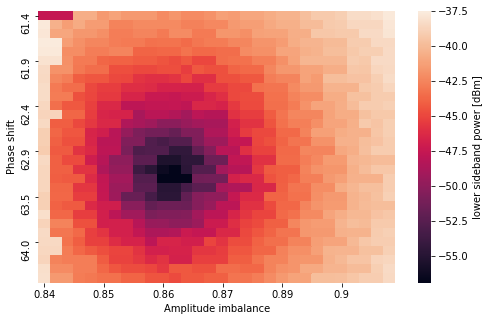

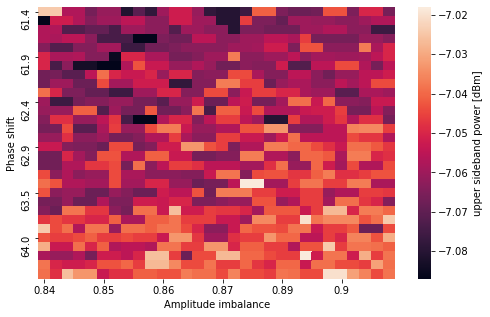

In [27]:
# Plot results of 2D sweep

# Store results in dataframe for easy plotting
lower_sideband_data = pd.DataFrame(lower_sideband_power,
                   index=np.round(phases, 1),
                   columns=np.round(qs, 2))

upper_sideband_data = pd.DataFrame(upper_sideband_power,
                   index=np.round(phases, 1),
                   columns=np.round(qs, 2))

# sideband_ratio_data = pd.DataFrame(lower_divided_by_upper,
#                    index=np.round(phases, 1),
#                    columns=np.round(qs, 2))

fig1, ax1 = plt.subplots(figsize=(8, 5))    
ax1 = sns.heatmap(lower_sideband_data, xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'lower sideband power [dBm]'})
ax1.set(ylabel='Phase shift', xlabel='Amplitude imbalance')

fig2, ax2 = plt.subplots(figsize=(8, 5))    
ax2 = sns.heatmap(upper_sideband_data, xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'upper sideband power [dBm]'})
ax2.set(ylabel='Phase shift', xlabel='Amplitude imbalance')

# fig3, ax3 = plt.subplots(figsize=(8, 5))    
# ax3 = sns.heatmap(sideband_ratio_data, xticklabels=25,  yticklabels=25,  cbar_kws={'label': 'lower/upper sideband power [dBm]'})
# ax3.set(ylabel='Phase shift', xlabel='Amplitude imbalance')

In [28]:
# Reset optimum values

set_optimal_point(opt_phase, opt_q)

opt_phase = phases[np.where(lower_sideband_power == np.amin(lower_sideband_power))[0][0]]
opt_q = qs[np.where(lower_sideband_power == np.amin(lower_sideband_power))[1][0]]

print(opt_phase, opt_q)

63.2568058076225 0.8643738656987296


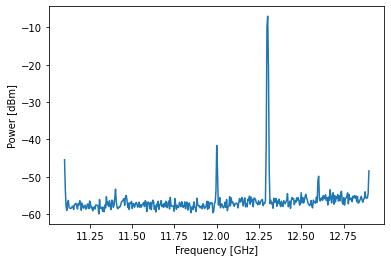

In [29]:
amp_i_opt = 2 * opt_q / (1 + opt_q) * a0
amp_q_opt = 2 * a0 / (1 + opt_q) 

# Set optimal I and Q amplitudes
hd.setd('sines/0/amplitudes/0', amp_i_opt)
hd.setd('sines/1/amplitudes/1', amp_q_opt)

# Set optimal phaseshift
hd.setd('sines/0/phaseshift', opt_phase)

sa.plot_trace()

In [30]:
# Copy carrier supression code from above

# Define area of 2D sweep of DC offest
# dc_min_i = 0
# dc_max_i = 100e-3
# dc_max_q = 0
# dc_min_q = -100e-3

dc_min_i = -5e-3
dc_max_i = 15e-3
dc_min_q = -5e-3
dc_max_q = 15e-3

num_points = 30

In [31]:
def sweep_dc_offsets(dc_min_i, dc_max_i, dc_min_q, dc_max_q, num_points):
    # Sweep 2D parameter space of DC offsets and record carrier power
    voltages_i = np.linspace(dc_min_i, dc_max_i, num_points)
    voltages_q = np.linspace(dc_min_q, dc_max_q, num_points)

    carrier_power = np.zeros((num_points, num_points))

    for i, j in it.product(range(num_points), repeat=2):

        # Set I DC-offset
        hd.setd('sigouts/0/offset', voltages_i[i])

        # Set Q DC-offset
        hd.setd('sigouts/1/offset', voltages_q[j])

        # Read carrier power
        carrier_power[i,j] = carrier_marker.get_power()
        print(f'{i/num_points * 100} % done')
        clear_output(wait=True)
        
    return carrier_power, voltages_i, voltages_q

In [32]:
carrier_power, voltages_i, voltages_q = sweep_dc_offsets(dc_min_i, dc_max_i, dc_min_q, dc_max_q, num_points)

96.66666666666667 % done


[Text(0.5, 24.0, 'DC offset Q signal [mV]'),
 Text(51.0, 0.5, 'DC offset I signal [mV]')]

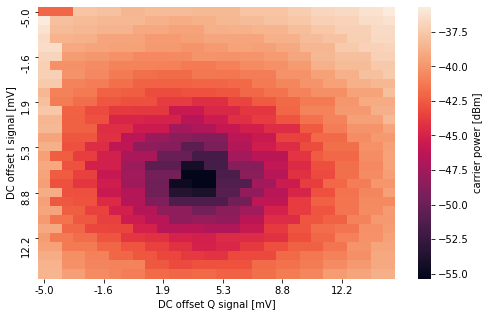

In [33]:
# Store results in dataframe for easy plotting
dc_sweep_data = pd.DataFrame(carrier_power,
                   columns=np.round(voltages_q/1e-3, 1),
                   index=np.round(voltages_i/1e-3, 1))

fig, ax = plt.subplots(figsize=(8, 5))    
ax = sns.heatmap(dc_sweep_data, xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'carrier power [dBm]'})
ax.set(xlabel='DC offset Q signal [mV]', ylabel='DC offset I signal [mV]')

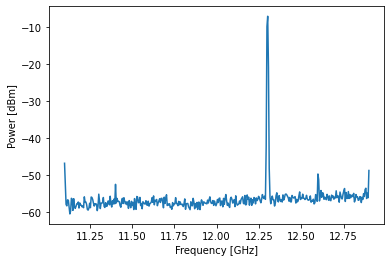

0.007413793103448277 0.0032758620689655174


In [34]:
# Retrieve optimal DC offsets
dc_offset_i_opt = voltages_i[np.where(carrier_power == np.amin(carrier_power))[0][0]]
dc_offset_q_opt = voltages_q[np.where(carrier_power == np.amin(carrier_power))[1][0]]

# Set optimal offset
hd.setd('sigouts/0/offset', dc_offset_i_opt)
hd.setd('sigouts/1/offset', dc_offset_q_opt)

sa.plot_trace()
print(dc_offset_i_opt, dc_offset_q_opt)

In [35]:
# # Finer sweep over I and Q offsets

# cushion_param = 2

# dc_q_cushion = cushion_param*(dc_max_q-dc_min_q)/num_points
# dc_i_cushion = cushion_param*(dc_max_i-dc_min_i)/num_points

# # Reset sweep window to zoom in on minimum
# dc_max_i = dc_offset_i_opt + dc_i_cushion
# dc_min_i = dc_offset_i_opt - dc_i_cushion
# dc_max_q = dc_offset_q_opt + dc_q_cushion
# dc_min_q = dc_offset_q_opt - dc_q_cushion

# num_points = 30

# sweep_dc_offsets(dc_min_i, dc_max_i, dc_min_q, dc_max_q, num_points)

# carrier_power, voltages_i, voltages_q = sweep_dc_offsets(dc_min_i, dc_max_i, dc_min_q, dc_max_q, num_points)

In [36]:
# # Return heatmap plot
# dc_sweep_data = pd.DataFrame(carrier_power,
#                    columns=np.round(voltages_q/1e-3, 1),
#                    index=np.round(voltages_i/1e-3, 1))

# fig, ax = plt.subplots(figsize=(8, 5))    
# ax = sns.heatmap(dc_sweep_data, xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'carrier power [dBm]'})
# ax.set(xlabel='DC offset Q signal [mV]', ylabel='DC offset I signal [mV]')

In [37]:
# # Retrieve optimal DC offsets
# dc_offset_i_opt = voltages_i[np.where(carrier_power == np.amin(carrier_power))[0][0]]
# dc_offset_q_opt = voltages_q[np.where(carrier_power == np.amin(carrier_power))[1][0]]

# # Set optimal offset
# hd.setd('sigouts/0/offset', dc_offset_i_opt)
# hd.setd('sigouts/1/offset', dc_offset_q_opt)

# sa.plot_trace()
# print(dc_offset_i_opt, dc_offset_q_opt)

In [38]:
# # Define minimization function

# # Store voltage values during optimization
# dc_offset_traces = []
# carrier_power_traces = []


# def min_carrier(dc):
     
#     # Manually check constraints to make sure we can trust bounds
#     # in optimizer function.
#     assert dc_min_i <= dc[0] <= dc_max_i, f"{dc[0]} out of bound"
#     assert dc_min_q <= dc[1] <= dc_max_q, f"{dc[1]} out of bound"
    
#     # Append to storage
#     dc_offset_traces.append(dc)
    
#     # Set I DC-offset
#     hd.setd('sigouts/0/offset', dc[0])
        
#     # Set Q DC-offset
#     hd.setd('sigouts/1/offset', dc[1])
    
#     # Read carrier
#     power = carrier_marker.get_power()
#     carrier_power_traces.append(power)
    
#     # Print for debugging purposes.
#     print(f'Trying dc_i={dc[0]*1000:,.4f} mV, dc_q={dc[1]*1000:,.4f} mV, power={power}')   
#     clear_output(wait=True)
    
#     return power

In [39]:
# Run minimization function

# x0 = np.array([0, 0])
# bounds = [(dc_min_i, dc_max_i), (dc_min_q, dc_max_q)]
# res = minimizeCompass(min_carrier, bounds=bounds, x0=x0, deltatol=0.001, paired=False, deltainit=1)

In [40]:
# # Retrieve optimal DC offests
# dc_offset_i_opt = res['x'][0]
# dc_offset_q_opt = res['x'][1]

# # Set optimal offset
# hd.setd('sigouts/0/offset', dc_offset_i_opt)
# hd.setd('sigouts/1/offset', dc_offset_q_opt)

In [41]:
# sa.plot_trace()

Look good. Let's automate this minimization the same way as before.

In [42]:
# # Define minimization function

# def min_lsb(x):
     
#     phase = x[0]
#     q = x[1]
    
#     # Manually check constraints to make sure we can trust bounds
#     # in optimizer function.
#     #assert q_min <= q <= q_max, f"{q} out of bound"
#     #assert phase_min <= phase <= phase_max, f"{phase} out of bound"

#     # Calculate amplitudes
#     amp_i = 2 * q / (1 + q) * a0
#     amp_q = 2 * a0 / (1 + q)

#     # Set I and Q amplitudes
#     hd.setd('sines/0/amplitudes/0', amp_i)
#     hd.setd('sines/1/amplitudes/1', amp_q)

#     # Set phaseshift
#     hd.setd('sines/0/phaseshift', phase)

#     # Read lower sideband power
#     power =  lower_sb_marker.get_power()

    
#     # Print for debugging purposes.
#     print(f'Trying phase={phase:,.5f} deg, q={q:,.5f}, power={power}')   
#     clear_output(wait=True)
    
    
#     return power

This is where more work needs to be done. Optimization using `noisyopt` does not work. It's a good exercice to try this tough. I've also tried diverse `scipy` optimization algorithms, as well as some non-linear optimizer from MIT ([https://nlopt.readthedocs.io/en/latest/NLopt_Tutorial/]), without success. That being said, I did not spend too much time on this so it might be a good idea trying it again. 

In [43]:
# from scipy.optimize import differential_evolution

# def lower_divided_by_upper(x):

#     phase = x[0]
#     q = x[1]
#     x0 = [60,1]

#     # Calculate amplitudes
#     amp_i = 2 * q / (1 + q) * a0
#     amp_q = 2 * a0 / (1 + q)

#     # Set I and Q amplitudes
#     hd.setd('sines/0/amplitudes/0', amp_i)
#     hd.setd('sines/1/amplitudes/1', amp_q)

#     # Set phaseshift
#     hd.setd('sines/0/phaseshift', phase)
 
#     return lower_sb_marker.get_power() - upp_sb_marker.get_power()


# bounds = [(phase_min, phase_max), (q_min, q_max)]

# result = differential_evolution(lower_divided_by_upper, bounds, tol=0.01, mutation=0.8, polish=True)
# result.x, result.fun